# TimeSeries Exploratory Data Analysis
A better way to analyze timeseries data (and to poke at a causality hypothesis) is to simulate a slider effect. Essentially, we're going to compare how each aspect of Economic Freedom affects GDP per Capita in the short and long term.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
#from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


pd.set_option('display.max_columns', None)

In [2]:
df_base = pd.read_csv("..\Data_Sets\processed\economicData_1995-2022.csv")

### TimeSeriesGrowthAnalysis()
To assist us in this journey, let's create the function 'TimeSeriesGrowthAnalysis'. A summary of it:

**Purpose:** This function computes how changes in a predictor variable (like 'Overall Score') relate to changes in a target variable (like 'GDP per capita') over various time ranges.

**Working:** It shifts the time-series data by different time intervals (like 1 year, 2 years, etc) and calculates changes for both the predictor and target. For each time shift, it fits a linear regression model (with capability of using polynomials, but by default it's set to 1, e.g. Linear) to see how the change in predictor relates to the change in the target.

**Output:** The function outputs regression results (coefficients, intercepts, R^2 scores and RMSE) for each time shift and an augmented DataFrame (df_withDeltas) that contains computed changes for each time period.

In [3]:
def TimeSeriesGrowthAnalysis(
        df,
        predictor = 'Overall Score',
        target = 'GDP per capita (current USD)',
        quantiledTarget = 'Country Quintile',
        timeField = 'Index Year',
        mergeFields = ['Country Name', 'Index Year'],
        timePeriods_delta = [],
        polyOrder = 1
    ):
    '''
    In a nutshell, this function analyzes time-series data using a time-slider-type analysis.
    
    predictor = the (single) variable name you want to analyze. This function doesn't analyze more than one predictor at once.
    target = the dependent variable name we want to predict for.
    quantiledTarget = categorical data to split the data (useful for later visualization)
    timeField = the name of the time column you're using
    mergeFields = a list to define the Primary/Composite Key of the DataSet.
    timePeriods_delta = list of delta ranges to test the data against
    polyOrder = If you choose to test polynomial regression, simply insert the order. Linear Reg by default.
    '''
    
    # Initializing Base DataFrame
    cleaned_data = df[[
    mergeFields[0],
    mergeFields[1],
    predictor,
    target,
    quantiledTarget]].dropna()
    
    # Initializing Lists and DF to return
    coefficients = []
    intercepts = []
    r2_scores = []
    RMSE = []
    df_withDeltas = cleaned_data.copy() #just initializing, for later appending
    
    # Loop over each year delta, compute & store the merged data, and fit a Ridge Regression Model
    for delta in timePeriods_delta:
        # Create a shifted dataframe to compute the changes
        shifted_data = cleaned_data[[*mergeFields, target, predictor]].copy()
        shifted_data[timeField] -= delta
        
        merged_data = pd.merge(
            cleaned_data,
            shifted_data,
            on=mergeFields,
            suffixes=('', f'_plus_{delta}'),
            indicator = False,
            how = 'inner'
        )
        
        # If there's no data for this range, go to the next iteration
        if merged_data.shape[0] == 0:
            print(f"No overlapping data for {predictor} with a time delta of {delta}. Appending NaN values for this delta.")

            coefficients.append(np.nan)
            intercepts.append(np.nan)
            r2_scores.append(np.nan)
            RMSE.append(np.nan)
            continue


        # Compute the percentage change for predictor and target
        merged_data[f'{target}_change_{delta}']\
            = ((merged_data[f'{target}_plus_{delta}']\
               - merged_data[target])\
               / merged_data[target]) * 100

        merged_data[f'{predictor}_change_{delta}']\
            = (merged_data[f'{predictor}_plus_{delta}']\
                - merged_data[predictor])\
                / merged_data[predictor] * 100
        
        # Handle infinite values when dividing zero (from predictor percentage calc)
        merged_data[f'{predictor}_change_{delta}'].replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Filling NaN per Country with their mean value
        merged_data[f'{predictor}_change_{delta}']\
            .fillna(merged_data.groupby(by=['Country Name'])[f'{predictor}_change_{delta}']\
                    .mean().reset_index(drop=True), inplace=True)
        
        # Filling accross all countries with the mean value
        merged_data[f'{predictor}_change_{delta}']\
            .fillna(merged_data[f'{predictor}_change_{delta}']\
                    .mean(), inplace=True)

        
        # Merge results to df_withDeltas based on mergeFields
        df_withDeltas = pd.merge(
            df_withDeltas,
            merged_data[[*mergeFields, f'{predictor}_change_{delta}', f'{target}_change_{delta}']],
            on=mergeFields,
            how='left'
        )        
        
        # -------------------- Model Building & Fitting --------------------
        X = merged_data[f'{predictor}_change_{delta}'].values.reshape(-1, 1)        
        y = merged_data[f'{target}_change_{delta}']

        # Generate polynomial features    
        poly = PolynomialFeatures(degree=polyOrder)
        
        X_poly = poly.fit_transform(X)
        
        
        # Instantiate Regression
        model = LinearRegression().fit(X_poly, y)

        # Predict using the polynomial features
        yHat = model.predict(X_poly)

        # Store the results
        coefficients.append(sum(np.abs(model.coef_)))  # Note: This will now represent only the maximum term of the polynomial
        intercepts.append(model.intercept_)
        r2_scores.append(model.score(X_poly, y))
        RMSE.append(np.sqrt(mean_squared_error(y, yHat)))

    # Create a results DataFrame
    regression_results = pd.DataFrame({
        'Years Ahead': timePeriods_delta,
        'Coefficient (target to predictor % Change)': coefficients,
        'Intercept': intercepts,
        'R^2 Score': r2_scores,
        'RMSE': RMSE
    })
    
    return regression_results, df_withDeltas

### PlotTimeSeriesGrowthAnalysis()
To visualize how changes in the predictor variable (like 'Overall Score') correlate with changes in the target variable (like GDP per capita) for different time shifts.


In [4]:
def PlotTimeSeriesGrowthAnalysis(
        df,
        predictor = 'Overall Score',
        target = 'GDP per capita (current USD)',
        quantiledTarget = 'Country Quintile',
        timePeriods_delta = [],
        polyOrder = 3
    ):

    '''
    In a nutshell, a scatterplot of the data created in the function: TimeSeriesGrowthAnalysis
    See that function for more information on the variables.
    '''

    # Set up the subplots
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
    axes = axes.ravel()
    
    
    
    # Loop over each period delta, compute the merged data, and plot the data with the regression line
    for i, delta in enumerate(timePeriods_delta):
        
        predictor_column = f'{predictor}_change_{delta}'
        target_column = f'{target}_change_{delta}'

        # Check if the columns exist in the dataframe
        if predictor_column not in df.columns or target_column not in df.columns:
            print(f"No data for {predictor} with a time delta of {delta}. Skipping plot for this delta.")
            continue
        
        # Extract the features and target variable
        X = df[f'{predictor}_change_{delta}']
        y = df[f'{target}_change_{delta}']
        
        hue = df[quantiledTarget]
        quintile_order = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

        # Plot the data
        sns.scatterplot(x=X, y=y, hue=hue, ax=axes[i], s=10, palette="inferno", hue_order=quintile_order)    
                
        # Plot Non-Linear Regression line
        sns.regplot(x=X, y=y, ax=axes[i], order=polyOrder, color='tan', scatter_kws={'s': 0})

        axes[i].set_title(f'Periods Ahead = {delta}')
        axes[i].set_xlabel(f'% Change in {predictor}')
        axes[i].set_ylabel(f'% Change in {target}')
        axes[i].legend(title=quantiledTarget)
        
        # To better distinguish different quintiles (specially Q3)
        #axes[i].set_facecolor('tan')
        
        # Useful to make charts more consistent, not always useful though
        if i >= 4:
            ymin, ymax, xmin, xmax = -80, 1000, -60, 100
        else:
            ymin, ymax, xmin, xmax = -80, 200, -50, 50
            
        axes[i].set_ylim(ymin=ymin, ymax=ymax)
        axes[i].set_xlim(xmin=xmin, xmax=xmax)

    plt.tight_layout()
    plt.show()


## Economic Freedom : Analyzing each aspect on their own
We'll feed our functions with all 12 sub-categories of Heritage's Economic Freedom Index, alongside average aggregations with Overall Score, Rule of Law, Limited Government, Regulatory Efficiency and Open Markets.

In [5]:
df_base['Rule of Law'] = df_base[['Property Rights', 'Government Integrity', 'Judicial Effectiveness']].mean(axis=1)
df_base['Limited Government'] = df_base[['Government Spending', 'Tax Burden', 'Fiscal Health']].mean(axis=1)
df_base['Regulatory Efficiency'] = df_base[['Business Freedom', 'Monetary Freedom', 'Labor Freedom']].mean(axis=1)
df_base['Open Markets'] = df_base[['Financial Freedom', 'Investment Freedom', 'Trade Freedom']].mean(axis=1)

In [6]:
predictors = [
    'Overall Score',    
    'Rule of Law',
    'Limited Government',
    'Regulatory Efficiency',
    'Open Markets'
]

### Charts
PS: scroll-down or double click the output of the following cell.
PS²: To make it easier to visualize in public, I've capped the predictors list to contain just the aggregated aspects of Economic Freedom. Feel free to add all 12 aspects to the predictors List above, though.

## Overall Score: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.049100    5.381942   
1             2                                    0.081480   11.530375   
2             3                                    0.262321   17.819088   
3             4                                    0.491899   25.446708   
4             5                                    0.742493   34.181609   
5             6                                    1.038296   43.568492   
6             8                                    1.606986   65.650447   
7            10                                    2.412370   91.251162   
8            12                                    3.256589  117.082296   
9            15                                    3.899857  155.320622   
10           20                                    3.865106  206.236997   
11           25                                    5.530019  200.387211   

    R^2 Score        RMSE  
0    0.000211   14.212483  
1    0.000431   22.796033  
2    0.003455   32.182561  
3    0.009228   42.876653  
4    0.016186   55.053509  
5    0.023890   68.956685  
6    0.036728   99.508557  
7    0.055051  132.015927  
8    0.083964  151.473983  
9    0.108221  176.314242  
10   0.129347  196.085541  
11   0.235559  225.696906

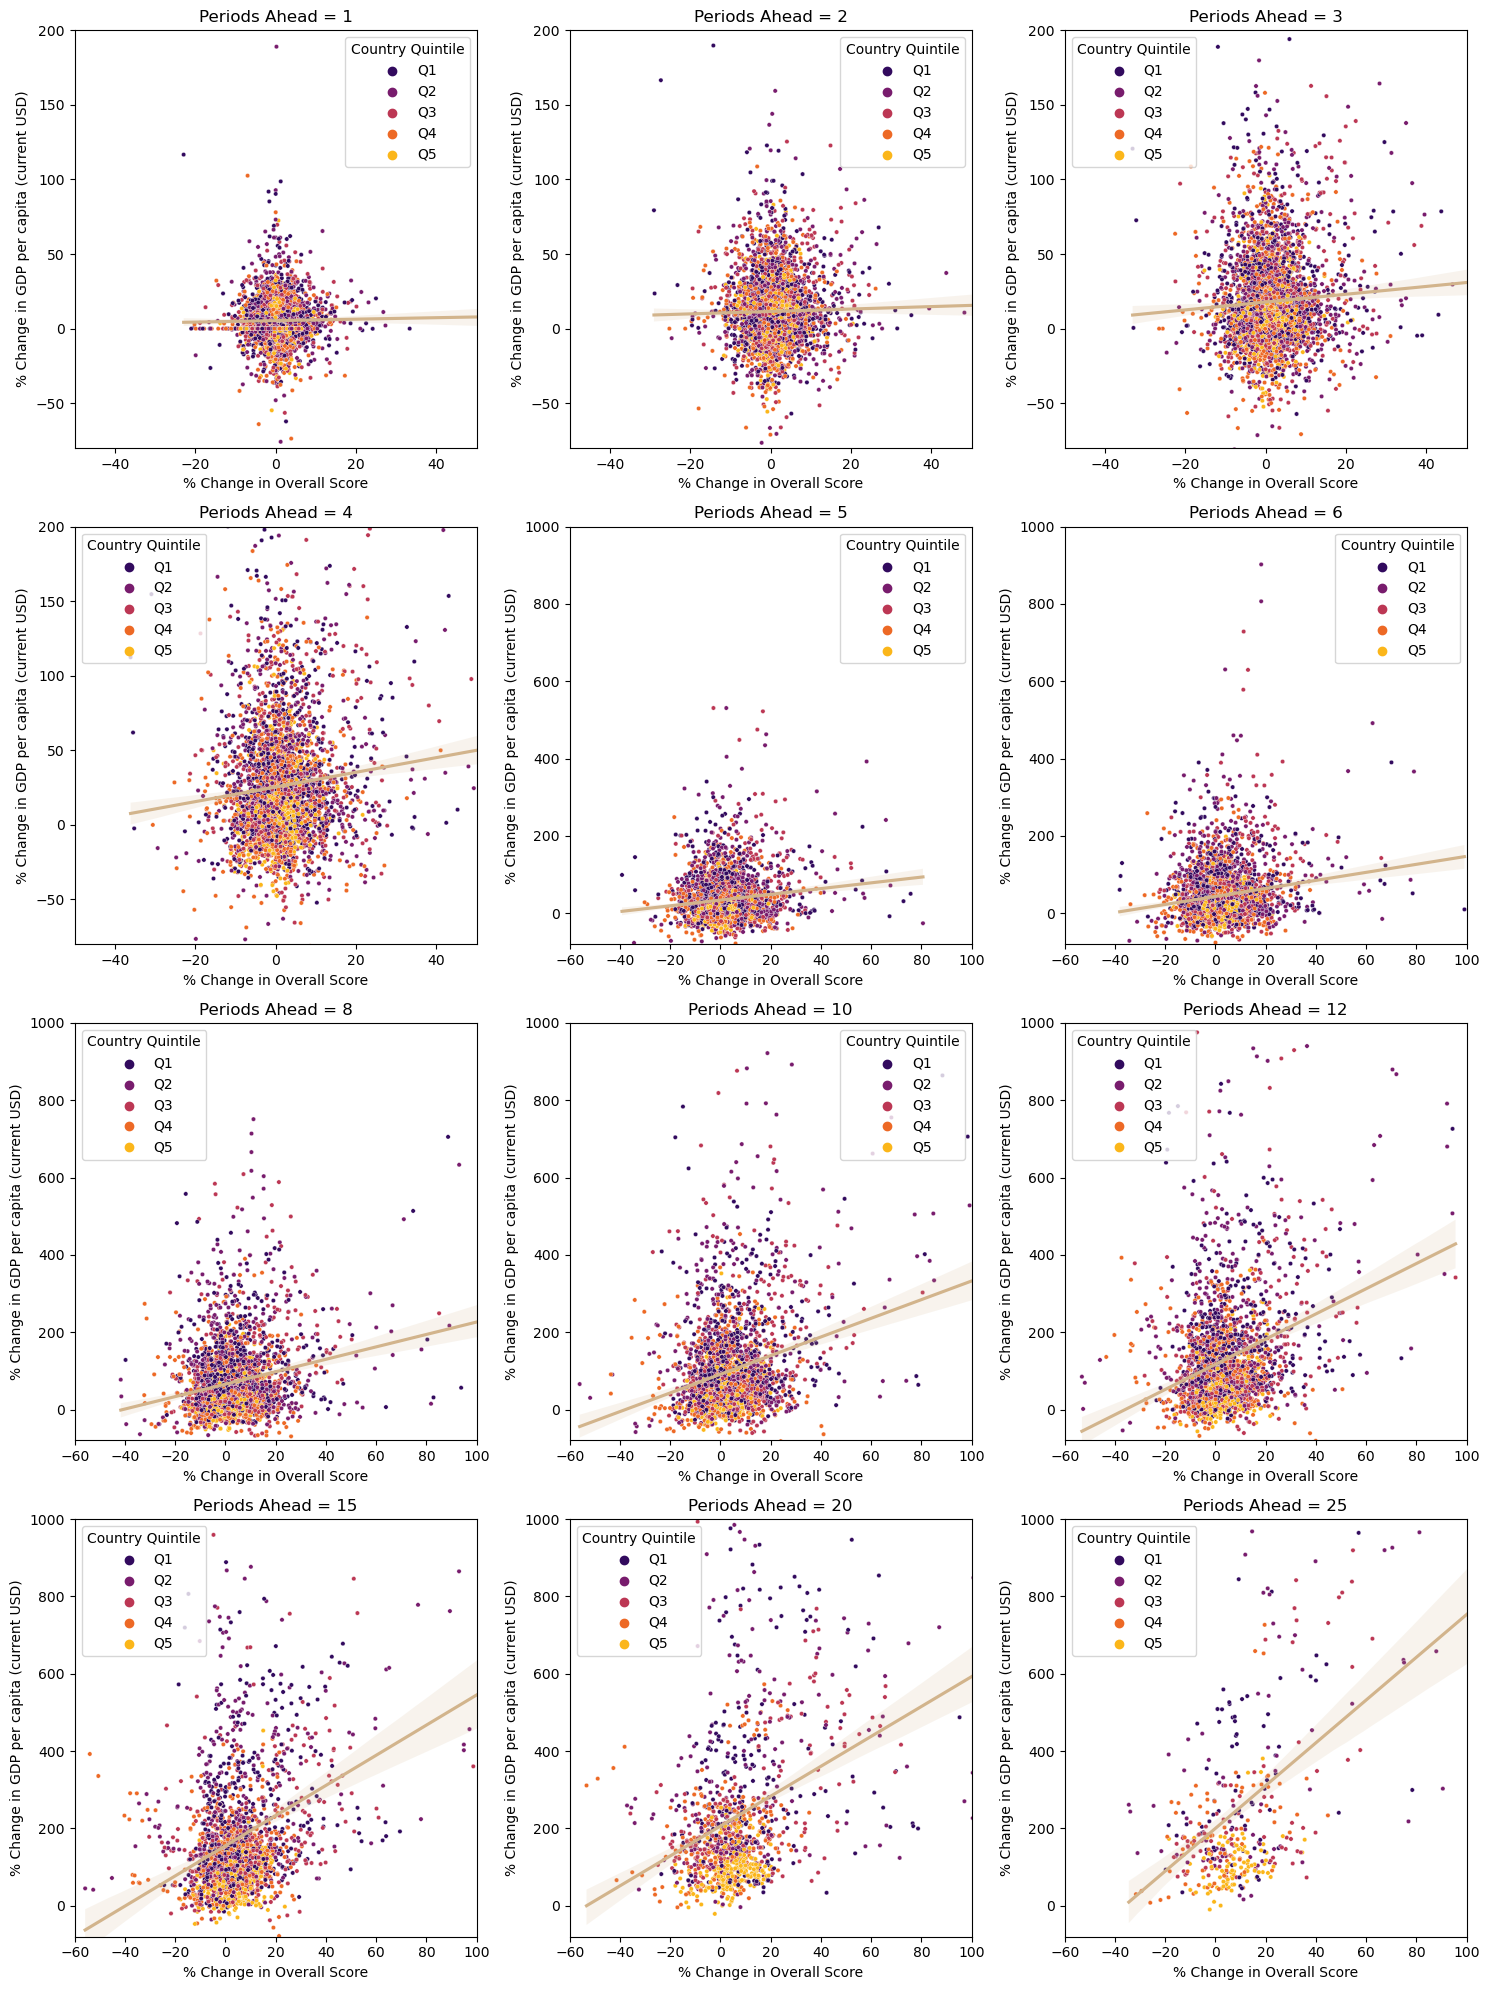




## Rule of Law: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.008652    5.353145   
1             2                                    0.023704   11.518821   
2             3                                    0.058373   18.192253   
3             4                                    0.092423   26.504398   
4             5                                    0.112807   36.205382   
5             6                                    0.129136   46.881646   
6             8                                    0.158910   71.894873   
7            10                                    0.113436  101.192965   
8            12                                    0.086522  132.042277   
9            15                                    0.249627  172.871101   
10           20                                    0.808600  219.508961   
11           25                                    1.461881  229.436993   

    R^2 Score        RMSE  
0    0.000065   14.261282  
1    0.000348   22.918458  
2    0.001618   32.346937  
3    0.002939   43.129520  
4    0.003342   55.521832  
5    0.003305   69.801971  
6    0.002955  101.374472  
7    0.000995  135.873405  
8    0.000522  158.387829  
9    0.004569  186.616772  
10   0.067094  203.825195  
11   0.140252  240.801060

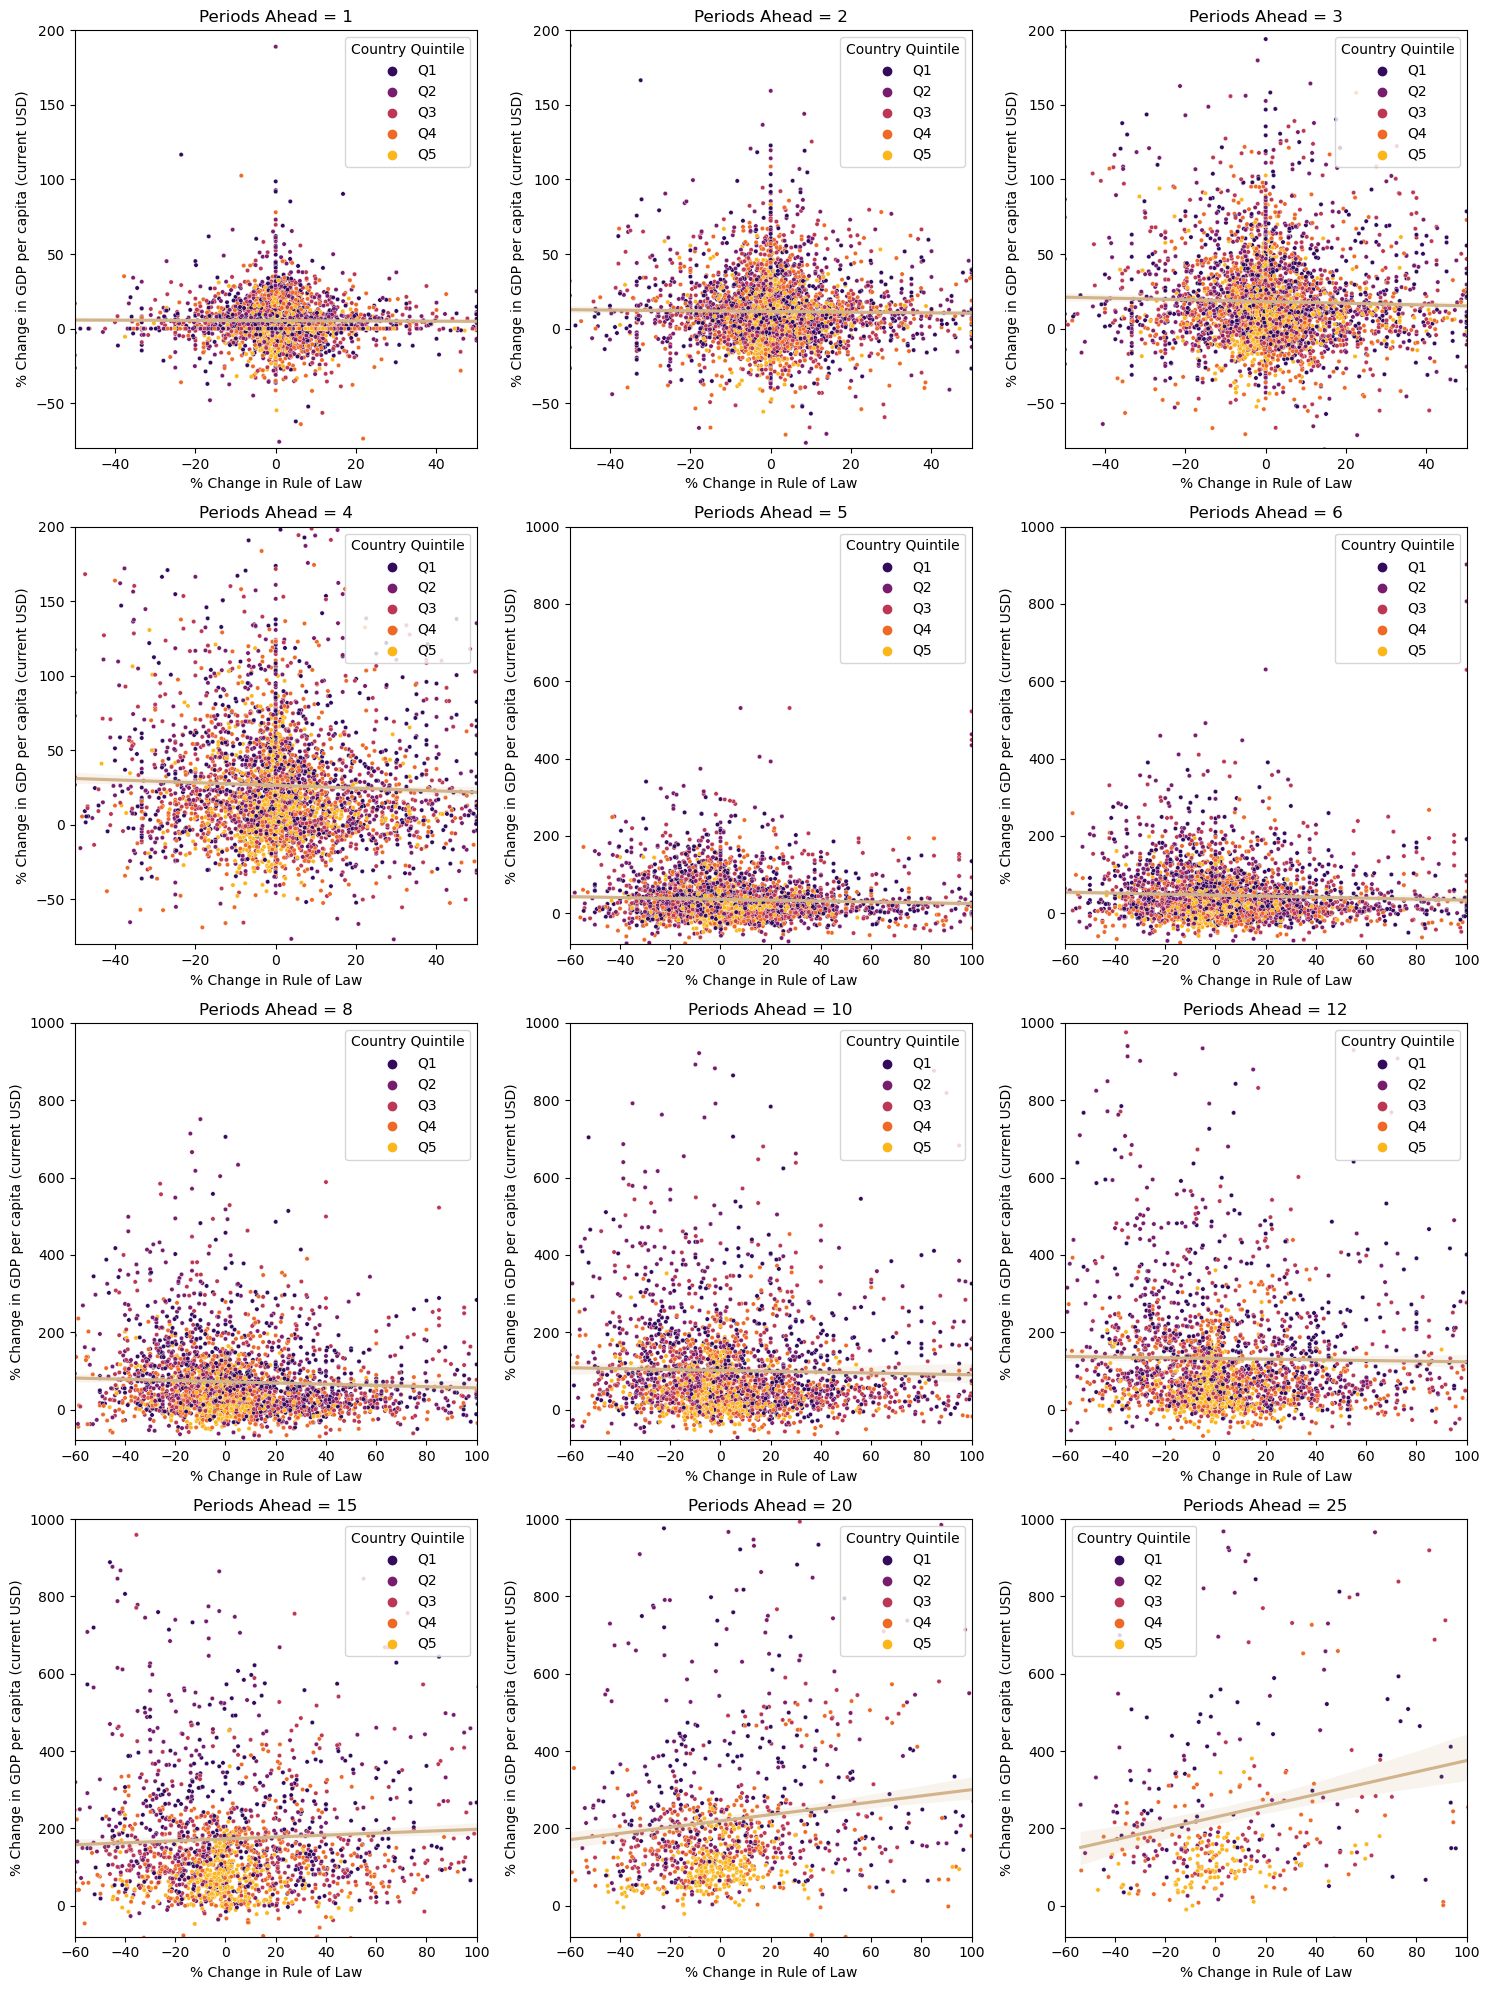




## Limited Government: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.036798    5.337614   
1             2                                    0.014510   11.470701   
2             3                                    0.039759   17.914269   
3             4                                    0.085018   25.808347   
4             5                                    0.149601   34.963110   
5             6                                    0.235309   44.919572   
6             8                                    0.420453   68.402205   
7            10                                    0.554588   96.926644   
8            12                                    0.626190  127.053632   
9            15                                    0.561415  171.739759   
10           20                                    0.094381  234.851879   
11           25                                    0.469919  251.233144   

    R^2 Score        RMSE  
0    0.000674   14.227757  
1    0.000088   22.889815  
2    0.000506   32.316164  
3    0.001663   43.121057  
4    0.003543   55.474051  
5    0.006023   69.667360  
6    0.010503  100.939950  
7    0.011592  135.071624  
8    0.013416  157.239980  
9    0.009014  186.009032  
10   0.000574  210.509691  
11   0.018040  256.623730

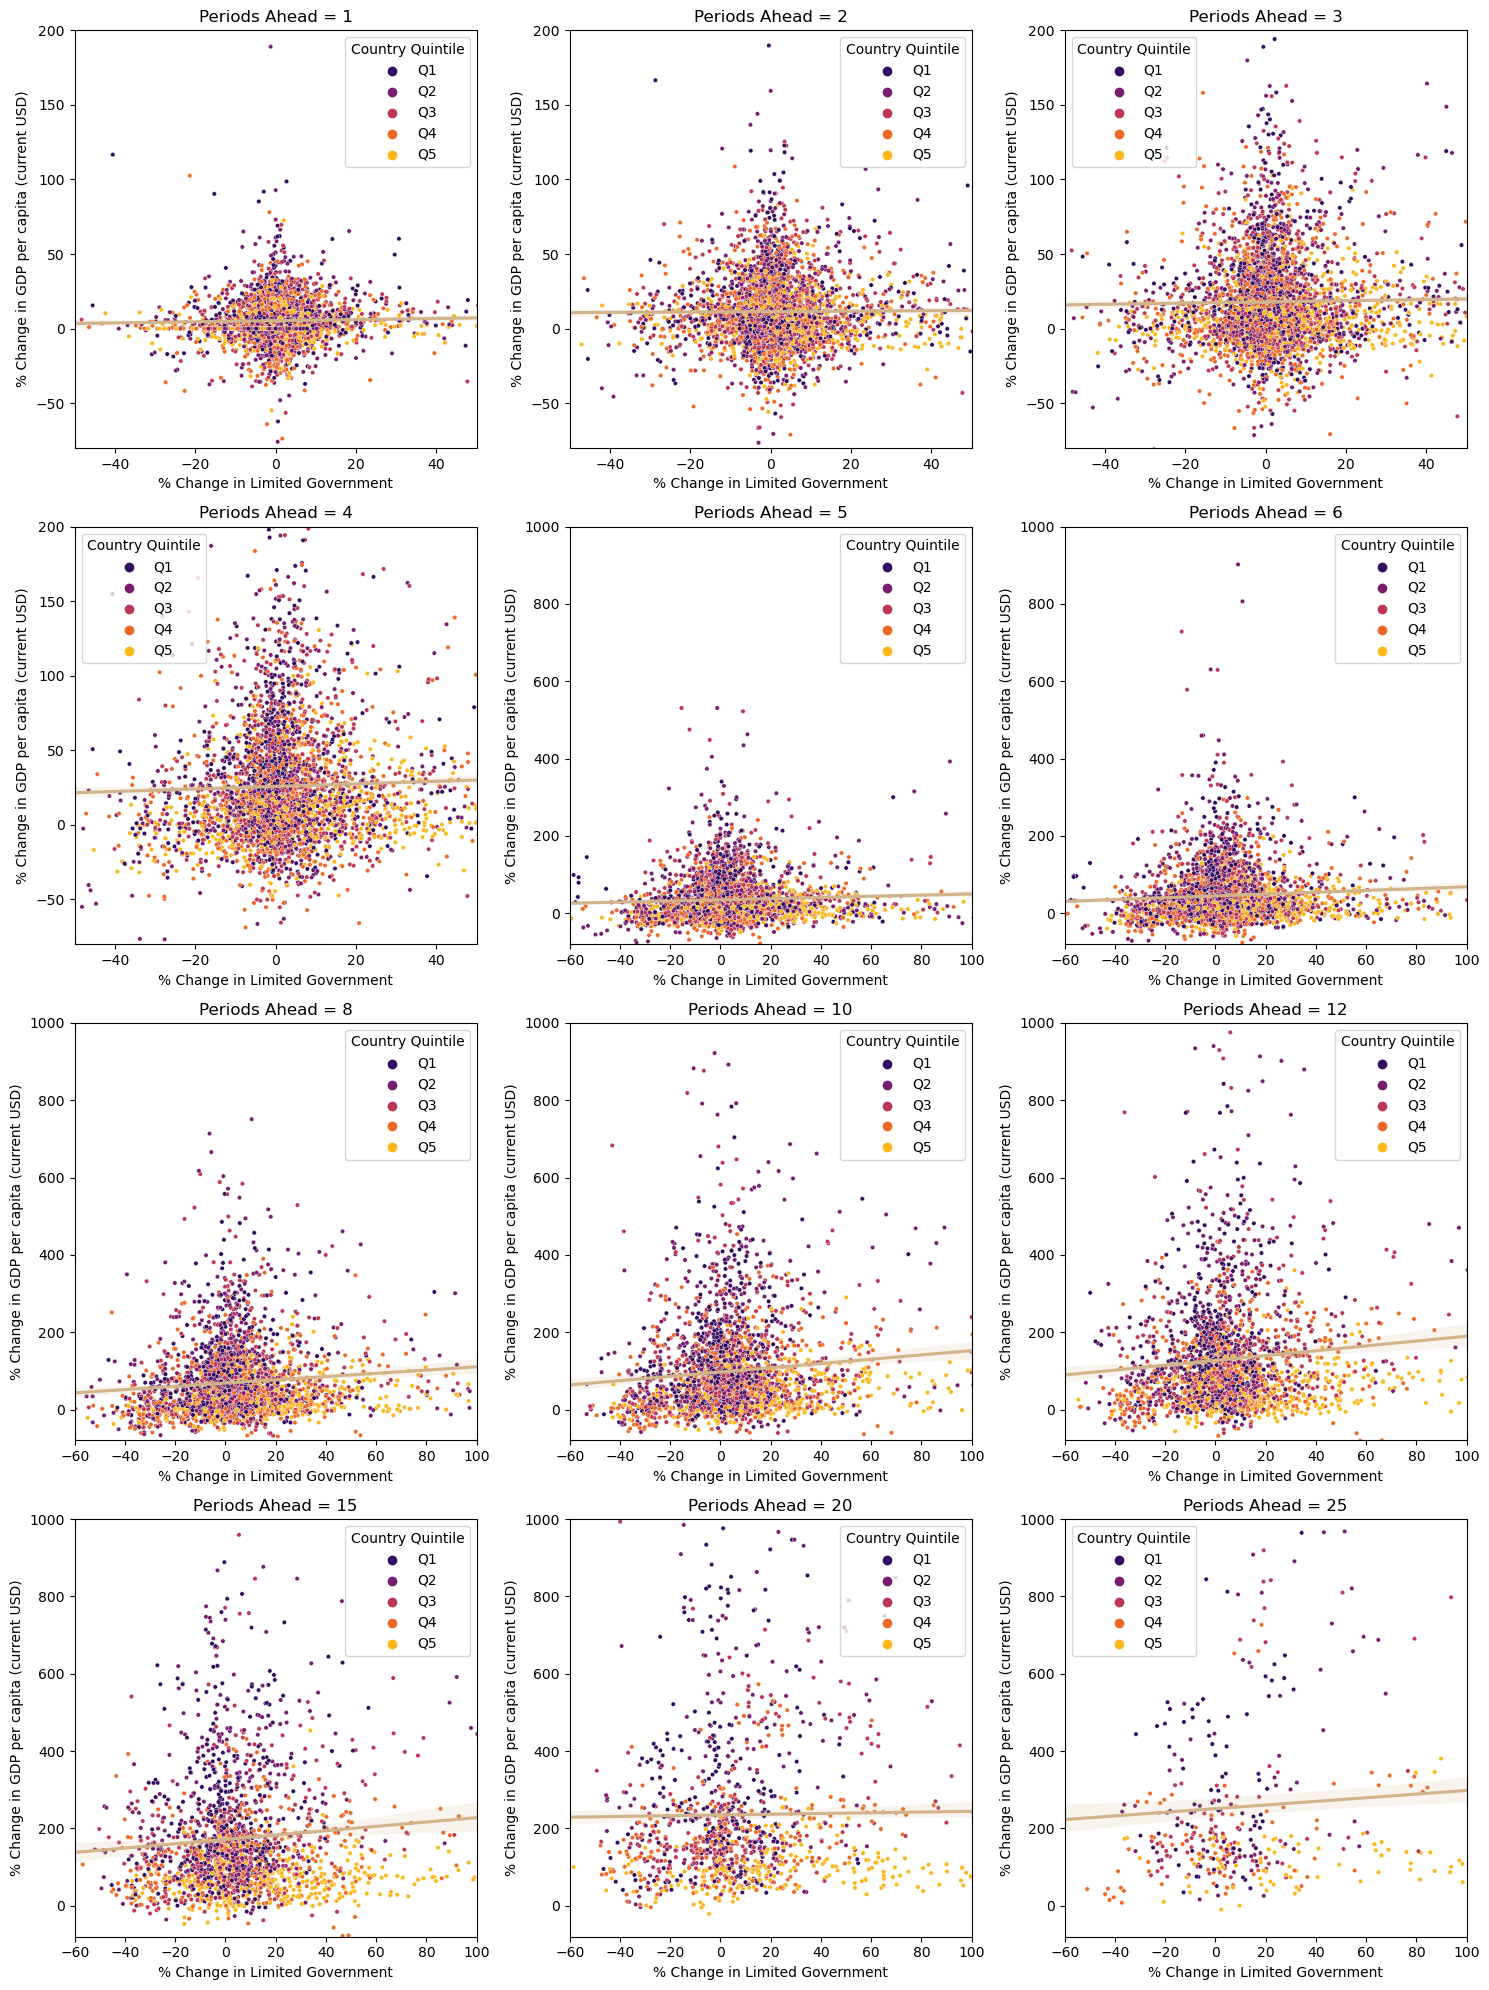




## Regulatory Efficiency: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.039894    5.359375   
1             2                                    0.060656   11.526795   
2             3                                    0.017298   17.940081   
3             4                                    0.088352   25.856226   
4             5                                    0.204632   34.996988   
5             6                                    0.349103   44.979018   
6             8                                    0.764122   68.202200   
7            10                                    1.383632   95.557331   
8            12                                    1.927993  123.802849   
9            15                                    2.270420  164.361865   
10           20                                    1.891923  219.555735   
11           25                                    2.647927  224.568054   

    R^2 Score        RMSE  
0    0.000534   14.257936  
1    0.001117   22.909645  
2    0.000073   32.371950  
3    0.001399   43.162815  
4    0.005494   55.461837  
5    0.011683   69.507972  
6    0.034362   99.765020  
7    0.075223  130.728185  
8    0.126504  148.069515  
9    0.168825  170.526277  
10   0.135287  196.234349  
11   0.232348  227.538458

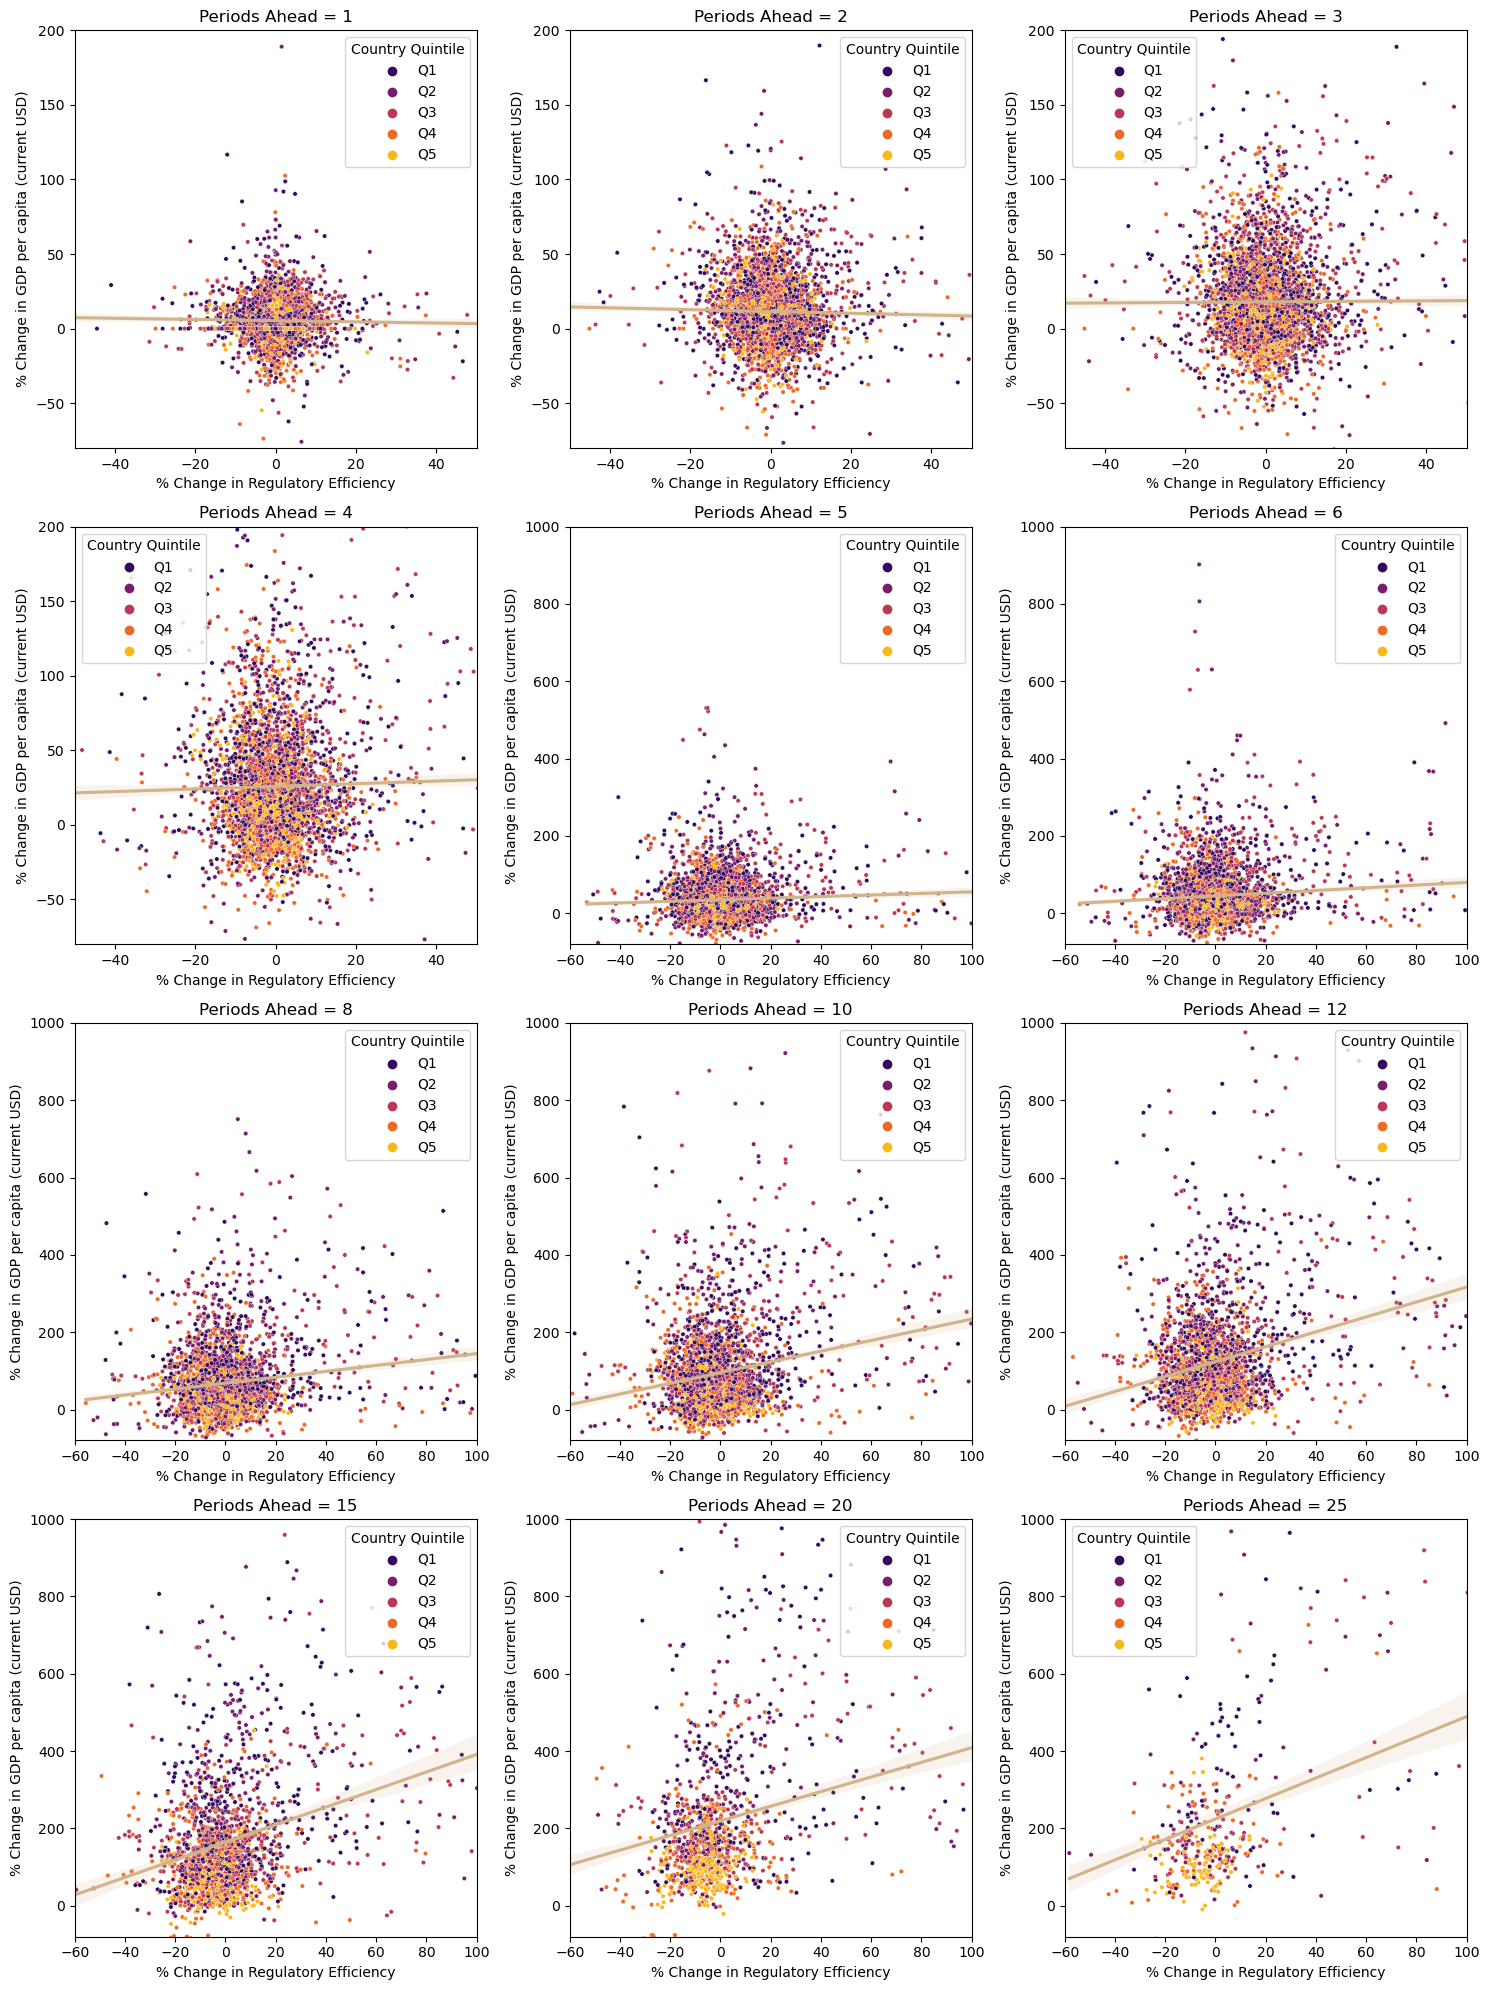




## Open Markets: Results


Years Ahead  Coefficient (target to predictor % Change)   Intercept  \
0             1                                    0.016312    5.331866   
1             2                                    0.083463   11.334727   
2             3                                    0.150250   17.623576   
3             4                                    0.198928   25.413231   
4             5                                    0.251561   34.443056   
5             6                                    0.333127   44.183068   
6             8                                    0.518363   66.938440   
7            10                                    0.684778   94.421505   
8            12                                    0.784561  123.457217   
9            15                                    0.814286  165.976396   
10           20                                    0.713871  223.709512   
11           25                                    2.210085  225.208030   

    R^2 Score        RMSE  
0    0.000101   14.262178  
1    0.001851   22.903001  
2    0.004231   32.308933  
3    0.005357   43.084886  
4    0.006239   55.451422  
5    0.008045   69.643003  
6    0.011125  100.958266  
7    0.011810  135.135956  
8    0.012333  157.449250  
9    0.010962  185.912990  
10   0.008060  209.923365  
11   0.056101  250.848131

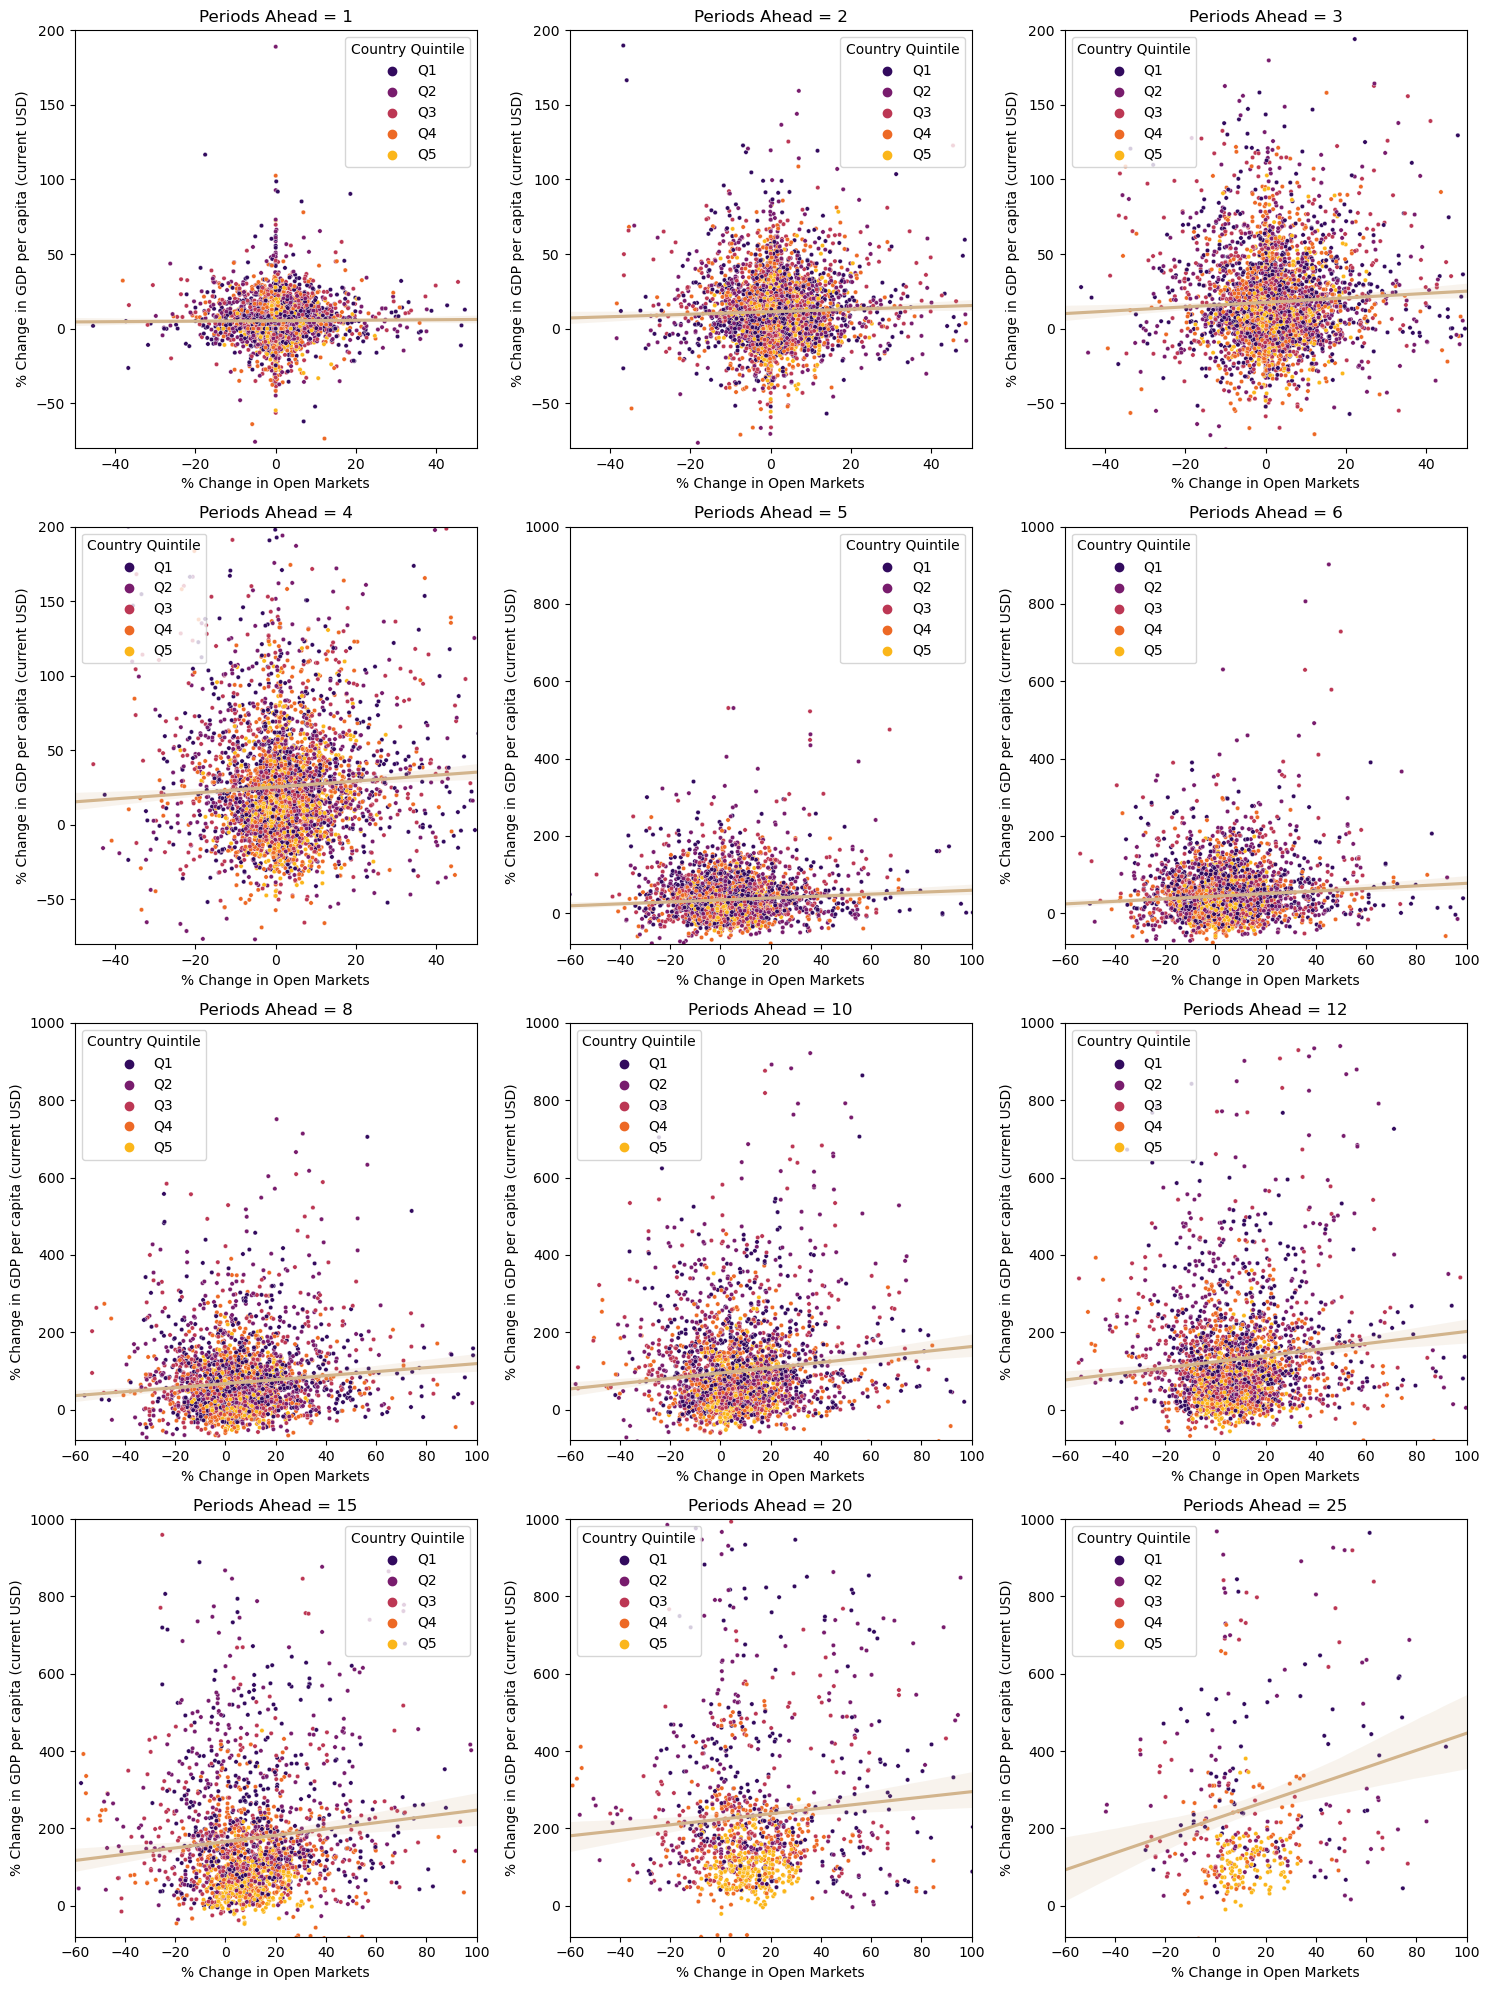

In [7]:
# Create an empty DataFrame to store coefficients and R^2 scores for year 6
summaryData = pd.DataFrame(columns=['Predictor', 'Coefficient (Year 6)', 'R^2 Score (Year 6)', 'RMSE (Year 6)'])

# Initialize another DataFrame to store the raw data, for later exporting
export_df = df_base[[
    'Country Name',
    'Index Year',
    'GDP per capita (current USD)',
    'Country Quintile']].dropna().copy()

#years_delta = [6]
years_delta = [1,2,3,4,5,6,8,10,12,15,20,25]
polyOrder = 1
toExportData = False # I recommend using this feature with only a single year in years_delta

# Loop through each predictor
for predictor in predictors:
    print(f"## {predictor}: Results")
    regression_results, df_withDeltas \
            = TimeSeriesGrowthAnalysis(df_base, polyOrder = polyOrder, timePeriods_delta=years_delta, predictor=predictor)

    # Extract the coefficient and R^2 score for year 6 
    year6_data = regression_results[regression_results['Years Ahead'] == 6]
    coeff_for_year6 = year6_data['Coefficient (target to predictor % Change)'].values
    r2_for_year6 = year6_data['R^2 Score'].values
    RMSE_for_year6 = year6_data['RMSE'].values
    
    # If True, add data to DataFrame, for later exporting
    if toExportData:
        
        # Exclude these columns to prevent duplication during merge
        exclude_keywords = ['GDP per capita (current USD)', 'Country Quintile', 'Country Name', 'Index Year']
        
        # Determine which columns from df_withDeltas are new and not already in export_df
        new_cols_to_merge = [col for col in df_withDeltas.columns if col not in exclude_keywords and col not in export_df.columns]
        
        # Only merge the new columns to avoid duplication
        export_df = pd.merge(
            export_df,
            df_withDeltas[new_cols_to_merge + ['Country Name', 'Index Year']],
            on=['Country Name', 'Index Year'],
            how='left'
        )
    
    # Append to the DataFrame
    new_row = pd.DataFrame({
        'Predictor': predictor, 
        'Coefficient (Year 6)': coeff_for_year6,
        'R^2 Score (Year 6)': r2_for_year6,
        'RMSE (Year 6)': RMSE_for_year6
    })
    summaryData = pd.concat([summaryData, new_row], ignore_index=True)

    # Display regression results
    display(regression_results)

    # Plot the analysis
    PlotTimeSeriesGrowthAnalysis(df_withDeltas, 
                             timePeriods_delta=years_delta, 
                             predictor=predictor,
                             polyOrder = polyOrder
                             )

    print("\n\n")

### Summary

In [8]:
summaryData = summaryData.round(3)
summaryData.sort_values(by='R^2 Score (Year 6)')

Predictor  Coefficient (Year 6)  R^2 Score (Year 6)  \
1            Rule of Law                 0.129               0.003   
2     Limited Government                 0.235               0.006   
4           Open Markets                 0.333               0.008   
3  Regulatory Efficiency                 0.349               0.012   
0          Overall Score                 1.038               0.024   

   RMSE (Year 6)  
1         69.802  
2         69.667  
4         69.643  
3         69.508  
0         68.957

### Thoughts

As you can see by looking at the summary and the charts, it is evident that certain predictors show a notable correlation in terms of magnitude as the delta rises. However, when evaluating precision, the relevance seems minimal—most instances report an _R²_ value of merely 4% even over a 25-year span.

This observed trend could be influenced by [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox). But when analyzing specific quintiles using the same methodologies, the outcomes largely mirror the overall findings.

Additionally, the graphical representation of some predictors closely resembles a normal distribution. This suggests that certain variables might be interrelated due to random chance rather than any useful connection.

While expecting a singular predictor to effectively forecast future GDP growth is unrealistic, evaluating each predictor separately reinforces our preliminary observation from the '02_EDA_01_SimplePlots' Notebook, which states: *"Certain elements of Economic Freedom carry more weight than others."*


## Next Step
Our forthcoming step involves investigating the potential of crafting a predictive model for future GDP growth by utilizing all predictors ***in tandem***.

In [9]:
if toExportData:
    export_df.to_csv(f"..\Data_Sets\processed\economicData_EF-Analysis_{years_delta[0]}yearsDelta.csv")